In [1]:
import findspark
findspark.init()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
spark = SparkSession.builder.config(conf=SparkConf()).getOrCreate()
# Print config
# print(spark.sparkContext.getConf().getAll())
path_to_csv = "./Datasets/Orlen.csv"

In [2]:
df = spark.read.csv(path_to_csv, header=True, inferSchema=True)
# print(df.show())

In [3]:
df_cleared = df.drop("Volume", "Adj Close")
# print(df_cleared.show())

In [4]:
from pyspark.sql.window import Window
import pyspark.sql.functions as func
df_lag = df_cleared.withColumn('prev_day_price',
                               func.lag(df_cleared['Close']).over(
                                   Window.orderBy("Date")))
# df_lag.show()

df_with_prev_day_price = df_lag.withColumn(
    'daily_return',
    (df_lag['Close'] - df_lag['prev_day_price']) / df_lag['Close'])
# df_with_prev_day_price.show()

df_test  = df_lag.withColumn(
    'RSI',
    (100 - (100/ (1 +() ))

In [5]:
from pyspark.sql import functions as F
labeled = df_with_prev_day_price.withColumn(
    'profit',
    (F.when(df_with_prev_day_price["daily_return"] < 0, 0).otherwise(1)))
# labeled.show()

In [6]:
final_df = labeled.where(labeled["daily_return"].isNotNull())
result_df = final_df
# final_df.show()

In [7]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
final_df = final_df.drop("prev_day_price").withColumnRenamed(
    existing="daily_return", new="Daily return")

converted_df = final_df.select(
    final_df["Open"].cast("float"), final_df["High"].cast("float"),
    final_df["Low"].cast("float"), final_df["Close"].cast("float"),
    final_df["Daily return"].cast("float"), final_df["profit"].cast("int"))

train, test = converted_df.randomSplit([0.1, 0.9])
print("We have %d training examples and %d test examples." % (train.count(),
                                                              test.count()))

We have 119 training examples and 1235 test examples.


In [8]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer
featuresCols = converted_df.columns
featuresCols.remove('profit')
print(featuresCols)

# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
vectorAssembler_dt = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")
# This identifies categorical features and indexes them.
vectorIndexer_dt = VectorIndexer(
    inputCol="rawFeatures", outputCol="features", maxCategories=4)

dt = DecisionTreeRegressor(labelCol="Close")

['Open', 'High', 'Low', 'Close', 'Daily return']


RMSE on our test set: 0.44653
+-----+-----------------+
|Close|       prediction|
+-----+-----------------+
|7.317|7.938999970753987|
|7.328|7.938999970753987|
|7.569|7.938999970753987|
|7.514|7.938999970753987|
|7.459|7.938999970753987|
|7.688|7.938999970753987|
|7.701|7.938999970753987|
|7.935|7.938999970753987|
|7.782|7.938999970753987|
|7.978|7.938999970753987|
|8.089|7.938999970753987|
|8.223|7.938999970753987|
|8.344|8.577999591827393|
|8.402|8.577999591827393|
|8.441|8.577999591827393|
|8.412|8.577999591827393|
|8.471|8.577999591827393|
|8.629|8.577999591827393|
|8.537|8.577999591827393|
|8.564|8.577999591827393|
+-----+-----------------+
only showing top 20 rows



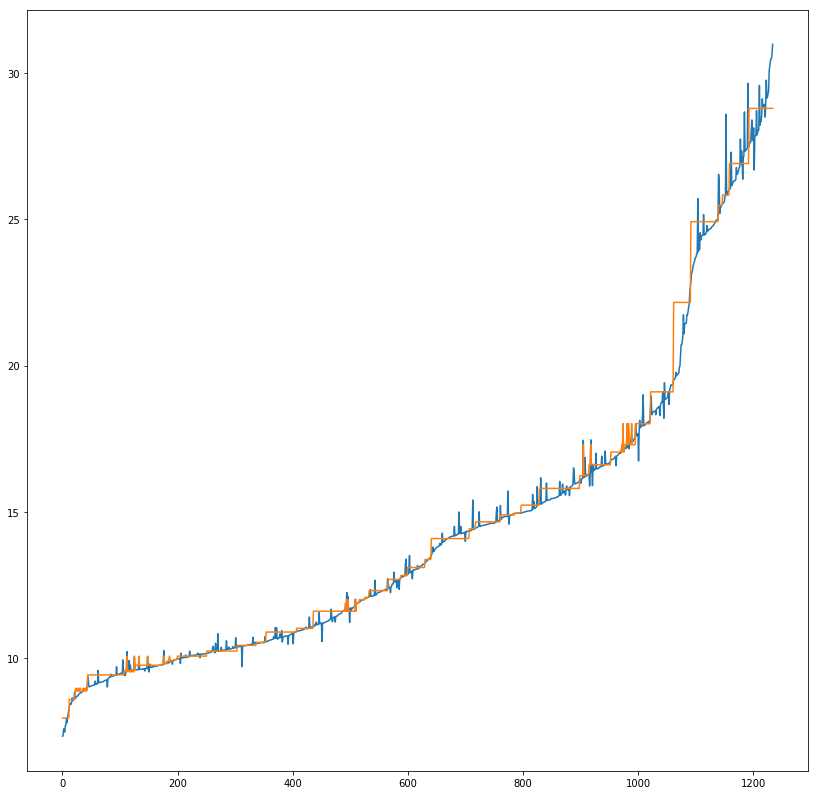

In [9]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
# Define a grid of hyperparameters to test:
#  - maxDepth: max depth of each decision tree in the GBT ensemble
# In this example notebook, we keep these values small.
# In practice, to get the highest accuracy, you would likely want to try deeper trees (10 or higher)
# and more trees in the ensemble (>100).

max_Depth_Range = list(range(1, 10))
min_InstancesPerNode = list(range(1, 8))
max_Bins = list(range(16, 48))


paramGrid_dt = ParamGridBuilder()\
    .addGrid(dt.maxDepth, max_Depth_Range)\
    .addGrid(dt.maxBins,max_Bins )\
    .addGrid(dt.minInstancesPerNode,min_InstancesPerNode )\
    .addGrid(dt.maxMemoryInMB, [1500]).build()

# We define an evaluation metric.  This tells CrossValidator how well we are doing by comparing the true
# labels with predictions.
evaluator_dt = RegressionEvaluator(
    metricName="rmse",
    labelCol=dt.getLabelCol(),
    predictionCol=dt.getPredictionCol())

# Declare the CrossValidator, which runs model tuning for us.
cv_dt = CrossValidator(
    estimator=dt, evaluator=evaluator_dt, estimatorParamMaps=paramGrid_dt)

pipeline_dt = Pipeline(stages=[vectorAssembler_dt, vectorIndexer_dt, cv_dt])

pipelineModel_dt = pipeline_dt.fit(train)

predictions_dt = pipelineModel_dt.transform(test)

rmse_dt = evaluator_dt.evaluate(predictions_dt)

print("RMSE on our test set: %g" % rmse_dt)

df_to_plot_dt = predictions_dt.drop("Open", "High", "Low", "Daily return",
                                    "profit", "rawFeatures", 'features')
df_to_plot_dt.show()

import matplotlib.pyplot as plt_dt
df_to_plot_dt = df_to_plot_dt.toPandas()
plt_dt.figure(figsize=(14, 14))
plt_dt.plot(df_to_plot_dt)
plt_dt.show()

In [10]:
# predictions.show()
# print(predictions.schema)
# predictions.select('features').show(20,False)

,Close,prediction
0,7.317000,7.939000
1,7.328000,7.939000
2,7.569000,7.939000
3,7.514000,7.939000
4,7.459000,7.939000
5,7.688000,7.939000
6,7.701000,7.939000
7,7.935000,7.939000
8,7.782000,7.939000
9,7.978000,7.939000


RMSE on our test set: 0.564258


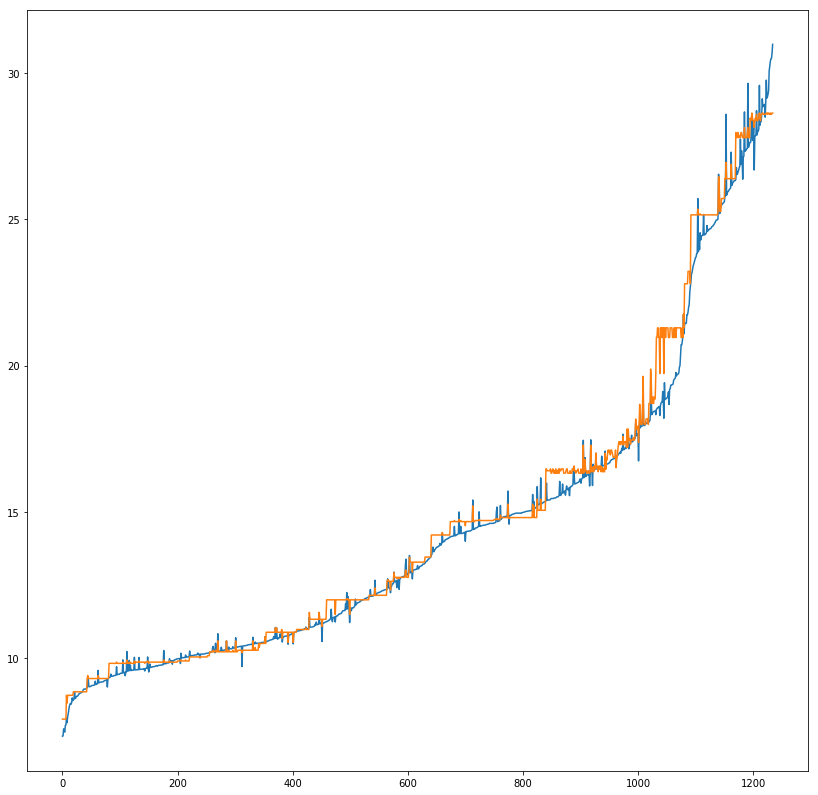

In [15]:
# Train a RandomForest model.
# Random Forest
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
# Define a grid of hyperparameters to test:
#  - maxDepth: max depth of each decision tree in the GBT ensemble
# In this example notebook, we keep these values small.
# In practice, to get the highest accuracy, you would likely want to try deeper trees (10 or higher)
# and more trees in the ensemble (>100).

featuresCols = converted_df.columns
featuresCols.remove('profit')
# print(featuresCols)

# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
vectorAssembler_rf = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")
# This identifies categorical features and indexes them.
vectorIndexer_rf = VectorIndexer(
    inputCol="rawFeatures", outputCol="features", maxCategories=4)

rf = RandomForestRegressor(labelCol='Close', featuresCol="features")

paramGrid_rf = ParamGridBuilder()\
    .addGrid(rf.maxDepth, [2,10,20])\
    .addGrid(rf.maxBins, [16, 32, 64 ,128])\
    .addGrid(rf.minInfoGain, [0.1])\
    .build()

# We define an evaluation metric.  This tells CrossValidator how well we are doing by comparing the true
# labels with predictions.
evaluator_rf = RegressionEvaluator(
    metricName="rmse",
    labelCol=rf.getLabelCol(),
    predictionCol=rf.getPredictionCol())

# Declare the CrossValidator, which runs model tuning for us.
cv_rf = CrossValidator(
    estimator=rf, evaluator=evaluator_rf, estimatorParamMaps=paramGrid_rf)

pipeline_rf = Pipeline(stages=[vectorAssembler_rf, vectorIndexer_rf, cv_rf])

pipelineModel_rf = pipeline_rf.fit(train)

predictions_rf = pipelineModel_rf.transform(test)

rmse_rf = evaluator_rf.evaluate(predictions_rf)

print("RMSE on our test set: %g" % rmse_rf)

df_to_plot_rf = predictions_rf.drop("Open", "High", "Low", "Daily return",
                                    "profit", "rawFeatures", 'features')

import matplotlib.pyplot as plt_rf
df_to_plot_rf = df_to_plot_rf.toPandas()
plt_rf.figure(figsize=(14, 14))
plt_rf.plot(df_to_plot_rf)
plt_rf.show()

RMSE on our test set: 0.6101


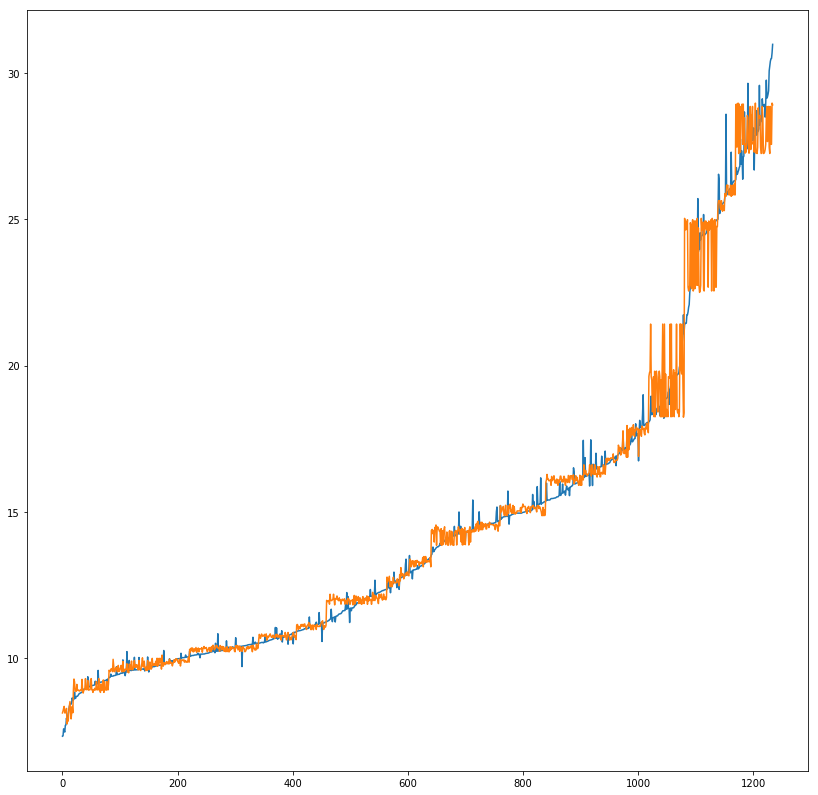

In [21]:
# Train a GBTrees model.
# Random Forest
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
# Define a grid of hyperparameters to test:
#  - maxDepth: max depth of each decision tree in the GBT ensemble
# In this example notebook, we keep these values small.
# In practice, to get the highest accuracy, you would likely want to try deeper trees (10 or higher)
# and more trees in the ensemble (>100).

featuresCols = converted_df.columns
featuresCols.remove('profit')
# print(featuresCols)

# This concatenates all feature columns into a single feature vector in a new column "rawFeatures".
vectorAssembler_gbt = VectorAssembler(
    inputCols=featuresCols, outputCol="rawFeatures")
# This identifies categorical features and indexes them.
vectorIndexer_gbt = VectorIndexer(
    inputCol="rawFeatures", outputCol="features", maxCategories=4)

gbt = GBTRegressor(labelCol='Close', featuresCol="features")

paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [2, 5])\
    .addGrid(gbt.maxIter, [10, 20])\
    .build()

# We define an evaluation metric.  This tells CrossValidator how well we are doing by comparing the true
# labels with predictions.
evaluator_gbt = RegressionEvaluator(
    metricName="rmse",
    labelCol=gbt.getLabelCol(),
    predictionCol=gbt.getPredictionCol())

# Declare the CrossValidator, which runs model tuning for us.
cv_gbt = CrossValidator(
    estimator=gbt, evaluator=evaluator_gbt, estimatorParamMaps=paramGrid_gbt)

pipeline_gbt = Pipeline(
    stages=[vectorAssembler_gbt, vectorIndexer_gbt, cv_gbt])

pipelineModel_gbt = pipeline_gbt.fit(train)

predictions_gbt = pipelineModel_gbt.transform(test)

rmse_gbt = evaluator_gbt.evaluate(predictions_gbt)

print("RMSE on our test set: %g" % rmse_gbt)

df_to_plot_gbt = predictions_gbt.drop("Open", "High", "Low", "Daily return",
                                      "profit", "rawFeatures", 'features')

import matplotlib.pyplot as plt_gbt
df_to_plot_gbt = df_to_plot_gbt.toPandas()
plt_gbt.figure(figsize=(14, 14))
plt_gbt.plot(df_to_plot_gbt)
plt_gbt.show()